In [ ]:
!git clone https://github.com/ultralytics/ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 5307, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 5307 (delta 118), reused 166 (delta 102), pack-reused 5081
Receiving objects: 100% (5307/5307), 4.31 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (3490/3490), done.


In [ ]:
!pip install -r /content/ultralytics/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
!mkdir /content/Road_Sign_Dataset

In [ ]:
!wget -O RoadSignDetectionDataset.zip https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2

--2023-02-26 21:23:15--  https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2
Resolving arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)... 13.224.255.8
Connecting to arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)|13.224.255.8|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-26 21:23:16 ERROR 404: Not Found.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
!unzip /content/drive/MyDrive/Road_Sign_Detection/Road_Sign_Detection.zip -d /content/Road_Sign_Dataset/

Archive:  /content/drive/MyDrive/Road_Sign_Detection/Road_Sign_Detection.zip
  inflating: /content/Road_Sign_Dataset/annotations/road0.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road1.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road10.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road100.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road101.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road102.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road103.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road104.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road105.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road106.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road107.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road108.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road109.xml  
  inflating: /content/Road_Sign_Dataset/annotations/road11.xml  
  inf

In [ ]:
print(extract_info_from_xml('/content/Road_Sign_Dataset/annotations/road116.xml'))

{'bboxes': [{'class': 'speedlimit', 'xmin': 310, 'ymin': 29, 'xmax': 369, 'ymax': 79}], 'filename': 'road116.png', 'image_size': (400, 225, 3)}


In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("/content/Road_Sign_Dataset/annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('/content/Road_Sign_Dataset/annotations/', x) for x in os.listdir('/content/Road_Sign_Dataset/annotations/') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('/content/Road_Sign_Dataset/annotations', x) for x in os.listdir('/content/Road_Sign_Dataset/annotations') if x[-3:] == "txt"]

100%|██████████| 877/877 [00:00<00:00, 5007.57it/s]


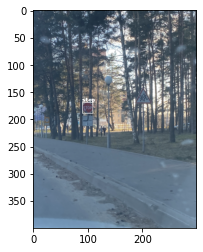

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("/content/Road_Sign_Dataset/annotations", "/content/Road_Sign_Dataset/images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join('/content/Road_Sign_Dataset/images', x) for x in os.listdir('/content/Road_Sign_Dataset/images')]
annotations = [os.path.join('/content/Road_Sign_Dataset/annotations', x) for x in os.listdir('/content/Road_Sign_Dataset/annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


In [ ]:
!mkdir /content/Road_Sign_Dataset/images/train /content/Road_Sign_Dataset/images/val /content/Road_Sign_Dataset/images/test /content/Road_Sign_Dataset/annotations/train  /content/Road_Sign_Dataset/annotations/val /content/Road_Sign_Dataset/annotations/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/content/Road_Sign_Dataset/images/train')
move_files_to_folder(val_images, '/content/Road_Sign_Dataset/images/val/')
move_files_to_folder(test_images, '/content/Road_Sign_Dataset/images/test/')
move_files_to_folder(train_annotations, '/content/Road_Sign_Dataset/annotations/train/')
move_files_to_folder(val_annotations, '/content/Road_Sign_Dataset/annotations/val/')
move_files_to_folder(test_annotations, '/content/Road_Sign_Dataset/annotations/test/')

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=/content/ultralytics/ultralytics/datasets/road_sign_data.yaml epochs=50 batch=8 name=yolov8n_v8_50e

In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.9/301.9 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from ultralytics import YOLO
 
# Load the model.
model = YOLO('yolov8n.pt')
 
# Training.
results = model.train(
   data='/content/ultralytics/ultralytics/datasets/road_sign_data.yaml',
   imgsz=640,
   epochs=100,
   batch=8,
   name='yolov8n_custom')

Ultralytics YOLOv8.0.47 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/ultralytics/ultralytics/datasets/road_sign_data.yaml, epochs=100, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_custom, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, 


0: 640x640 1 speedlimit, 45.6ms
Speed: 0.7ms preprocess, 45.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/yolov8n_custom4


[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
type: <class 'torch.Tensor'>
shape: torch.Size([1, 6])
dtype: torch.float32
 + tensor([[ 34.00000,   1.00000, 361.00000, 333.00000,   0.99737,   2.00000]], device='cuda:0')]


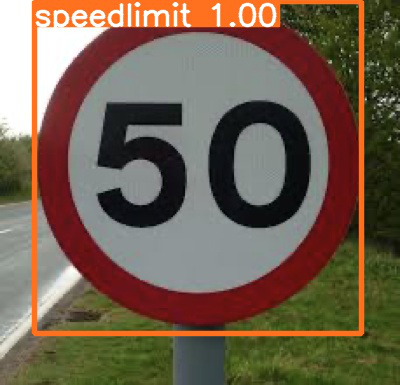

In [ ]:
from ultralytics import YOLO
from PIL import Image
import cv2

# from PIL
im1 = Image.open("/content/Road_Sign_Dataset/images/test/road100.png")
results = model.predict(source=im1, save=True)  # save plotted images
print(results)
display(Image.open('/content/runs/detect/yolov8n_custom4/image0.jpg'))


0: 640x480 1 speedlimit, 1 crosswalk, 24.2ms
Speed: 0.6ms preprocess, 24.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/yolov8n_custom4


[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
type: <class 'torch.Tensor'>
shape: torch.Size([2, 6])
dtype: torch.float32
 + tensor([[122.00000, 168.00000, 156.00000, 204.00000,   0.90849,   2.00000],
        [ 57.00000, 239.00000,  73.00000, 255.00000,   0.86999,   3.00000]], device='cuda:0')]


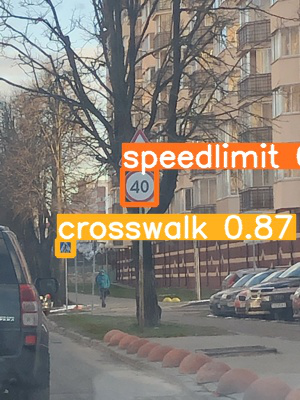

In [ ]:
from ultralytics import YOLO
from PIL import Image
import cv2

# from PIL
im1 = Image.open("/content/Road_Sign_Dataset/images/test/road315.png")
results = model.predict(source=im1, save=True)  # save plotted images
print(results)
display(Image.open('/content/runs/detect/yolov8n_custom4/image0.jpg'))

In [ ]:
success = model.export(format="onnx")

Ultralytics YOLOv8.0.47 🚀 Python-3.8.10 torch-1.13.1+cu116 CPU

PyTorch: starting from runs/detect/yolov8n_custom3/weights/best.pt with input shape (8, 3, 640, 640) BCHW and output shape(s) (8, 8, 8400) (5.9 MB)
requirements: YOLOv8 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6

requirements: 1 package updated per ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.13.1...
ONNX: export success ✅ 13.6s, saved as runs/detect/yolov8n_custom3/weights/best.onnx (11.7 MB)

Export comp